# Tutorial with Pennylane
This notebook demonstrates several examples of generating Quantum Convolutional Neural Networks (QCNNs) using the package. Default circuits/ansatzes for convolution and pooling operations are shown, such as the CRZ gate for convolutions and CNOT for pooling, to facilitate an easy visual representation of the package's functionality. The section [custom unitaries](#sec_customunitary) illustrates how to specify custom unitaries for convolutions, pooling, or other primitives.

___
*A cute robot building itself with artificial intelligence, pencil drawing -  generated with* [Dall E 2](https://openai.com/dall-e-2/)

<img src="../img/DALL·E 2022-08-17 11.48.32 - A cute robot building itself with artifical intelligence, pencil drawing.png" alt="drawing" width="200"/>

In [1]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Core library functionality
from hierarqcal import Qcnn, Qfree, Qconv, Qpool, Qdense, plot_motif, plot_motifs

In [3]:
# Specific to Pennylane
import pennylane as qml
from hierarqcal.pennylane import get_param_info_pennylane, execute_circuit_pennylane

# Specify QNode
dev = qml.device("default.qubit", wires=[i + 1 for i in range(8)])


@qml.qnode(dev)
def circuit(motif, params):
    response_wire = motif.head.Q_avail[-1]  # This is the 'last' available qubit
    execute_circuit_pennylane(motif, params)  # This executes the compute graph in order
    return qml.expval(qml.PauliZ(response_wire))


# Specify drawer
qml.drawer.use_style("black_white")

## Basic example
We create one of the architectures discussed in [Lourens et al.](https://arxiv.org/pdf/2210.15073.pdf). This architecture is semantically described as repeating a convolution of stride 1 and pooling from bottom to top on 8 qubits until one remain.

<img src="../img/hierarchical_motifs.drawio.svg" alt="hierarchical motifs" width="900"/>

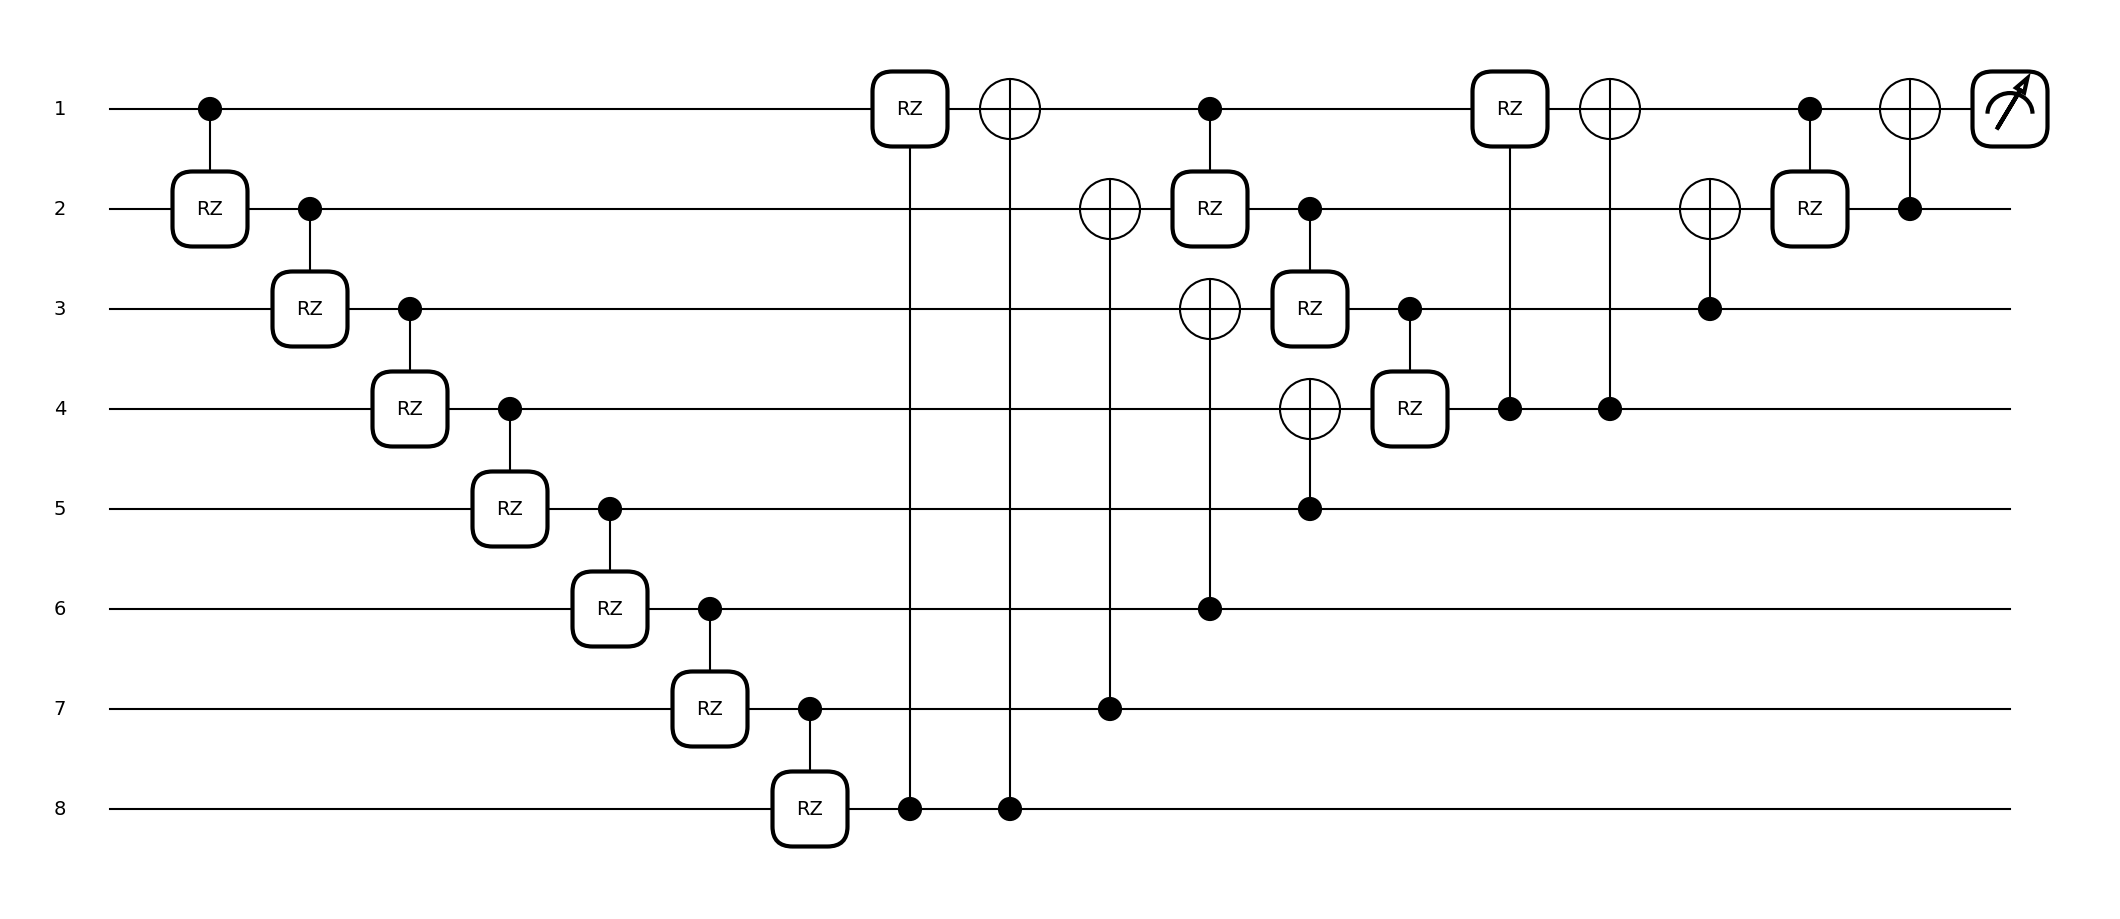

In [4]:
# Build circuit
motif = Qfree(8) + (Qconv(1) + Qpool(filter="right")) * 3

# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(motif)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(motif, params)

In [5]:
print(f"Number of coefficients:{total_coef_count}")
print(f"Coefficients per layer:\n{coef_indices}")

Number of coefficients:3
Coefficients per layer:
{0: range(0, 1), 1: None, 2: range(1, 2), 3: None, 4: range(2, 3), 5: None}


In [6]:
# Execute the circuit
print(circuit(motif, params))

1.0


## Building blocks
Circuit architectures are created by stacking motifs hierarchacially, the lowest level motifs (primitives) are building blocks for higher level ones. On a high level you can regard a primitive as a layer such as convolution or pooling and we're creating a sequence of layers for the circuit. This view only captures hierarchical architectures of two levels (*level 1 -> primitives, level 2 -> sequence of primitves*). The framework is more general in that there is no limit to the number of levels used to represent an architecture. See the comparison below:

**Layer view**
 - qcnn = (Convolution, Pooling, Convolution, Pooling, Convolution, Convolution, Convolution, Pooling, Convolution, Pooling)

**Hierarchical view**
 - m2_1 = (Convolution, Pooling)
 - m2_2 = (Convolution, Convolution)
 - m3_1 = (m2_1, m2_1)
 - qcnn = (m3_1, m2_2, m3_1)

### Free qubit primitive
We first need to specify the qubits for operations to act, this is achieved with the `Qfree` primitive. It is a special motif with no operational effect that makes qubits available and unavailable for succesive operations. 

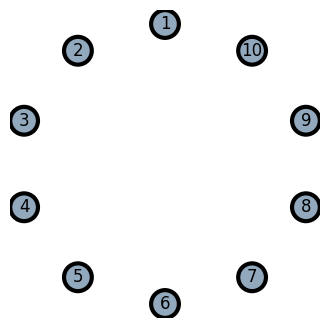

In [7]:
# Free primitive, can also recieve a list of qubit lables to make available.
free = Qfree(10)  # or Qfree([2,6,4,10]) or Qfree(["q1", "q2"])

fig, ax = plot_motif(free)

### Convolution primitive
To visualise the convolution operation we free up 8 qubits and add a convolution of stride 5 motif

Type of object	 <class 'hierarqcal.core.Qcnn'>
First motif	 <class 'hierarqcal.core.Qfree'>
Second motif	 <class 'hierarqcal.core.Qconv'>



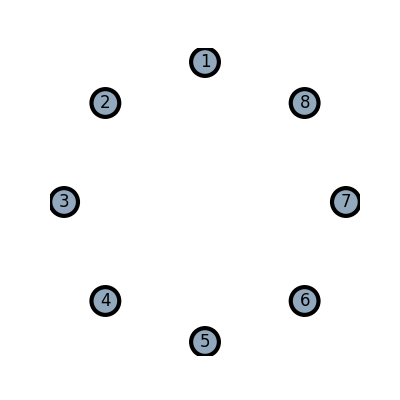
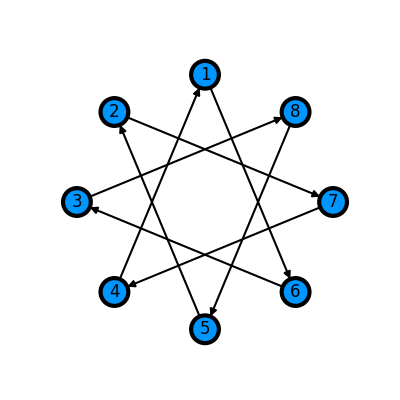

[<Figure size 400x400 with 1 Axes>, <Figure size 400x400 with 1 Axes>]

In [8]:
# Convolution of stride 3, try out other stride values
convolution = Qconv(stride=5)
conv_on_8_qubits = Qfree(8) + convolution

# Note the type of 'conv_on_8_qubits', it's a qcnn with two motifs: (Qfree, Qconv)
print(f"Type of object\t {type(conv_on_8_qubits)}")
print(f"First motif\t {type(conv_on_8_qubits.tail)}")
print(f"Second motif\t {type(conv_on_8_qubits.tail.next)}")
plot_motifs(conv_on_8_qubits, all_motifs=True)

**Pennylane Circuit representation**

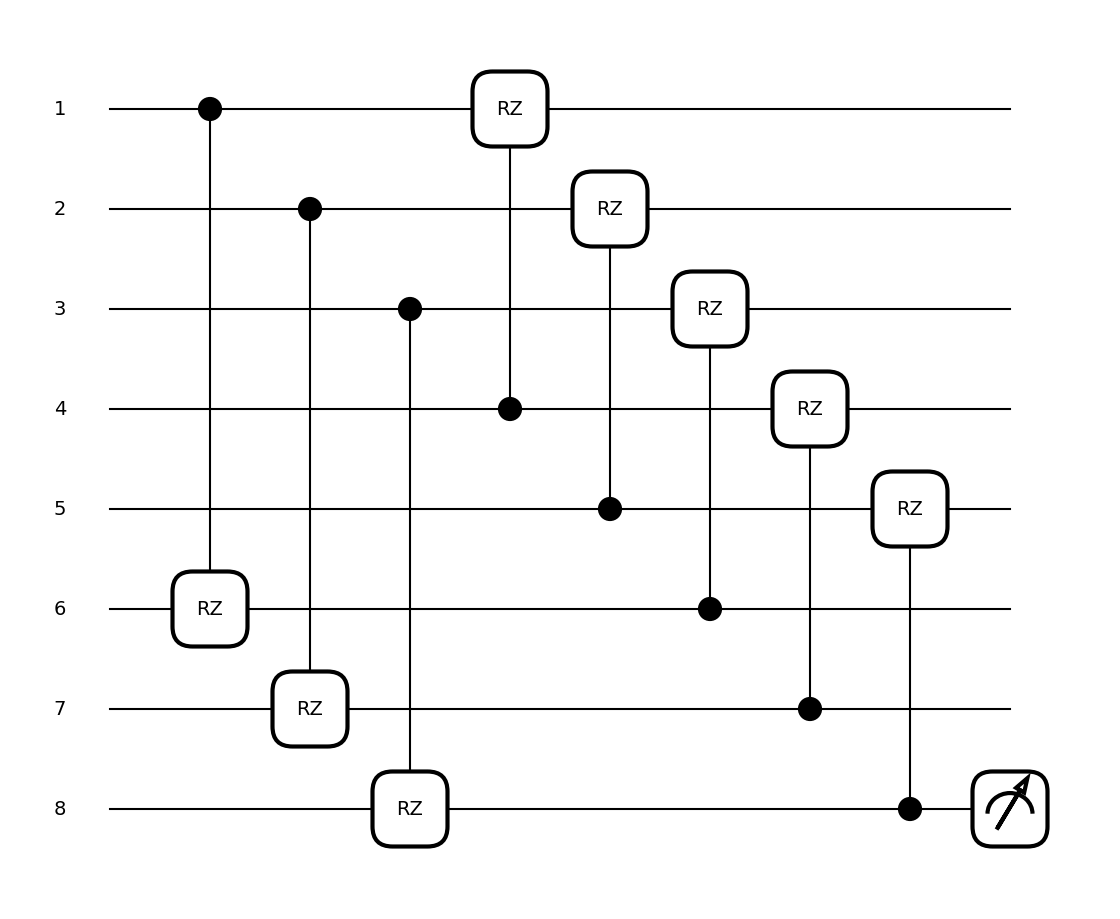

In [9]:
# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(conv_on_8_qubits)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(conv_on_8_qubits, params)

### Pooling primitive


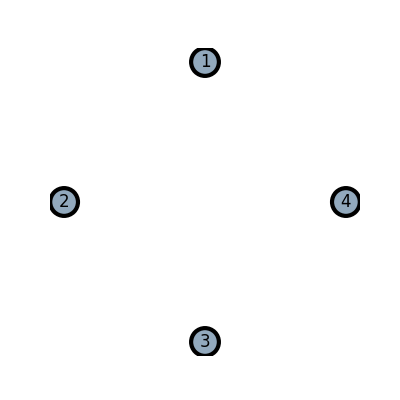
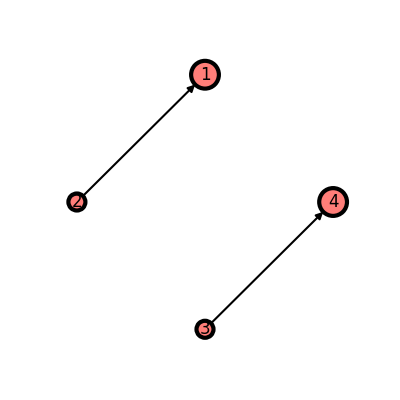

In [10]:
# Pooling from inside out, other values for filter: right, left, inside, outside, even, odd or a bitstring like 0100
pooling = Qpool(filter="inside")
pool_on_4_qubits = Qfree(4) + pooling

figs = plot_motifs(pool_on_4_qubits, all_motifs=True)

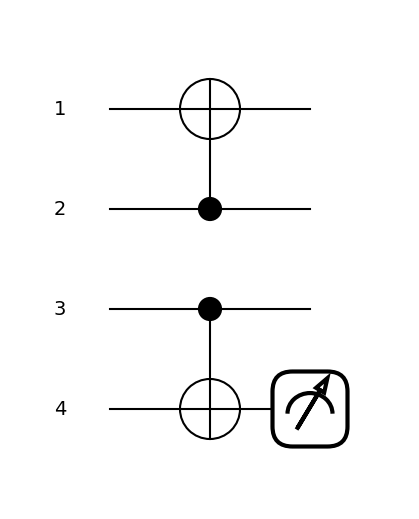

In [11]:
# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(pool_on_4_qubits)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(pool_on_4_qubits, params)

### Dense primitive


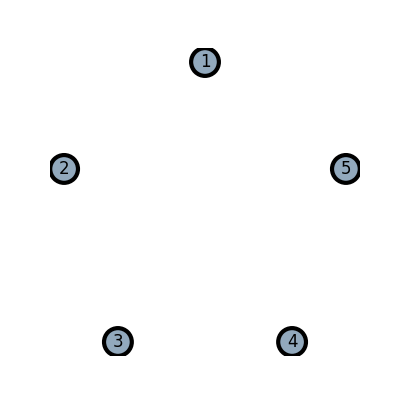
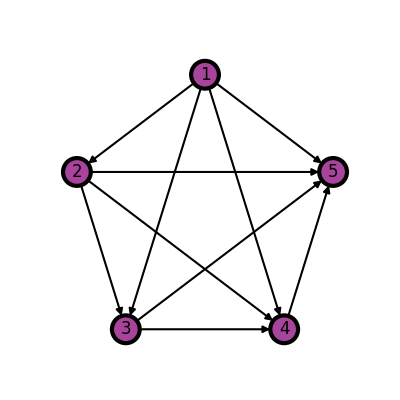

In [12]:
# Dense primitive, does all pairwise combinations between available qubits, for all permutations set permutations=True
dense = Qdense(permutations=False)
dense_on_5_qubits = Qfree(5) + dense

figs = plot_motifs(dense_on_5_qubits, all_motifs=True)

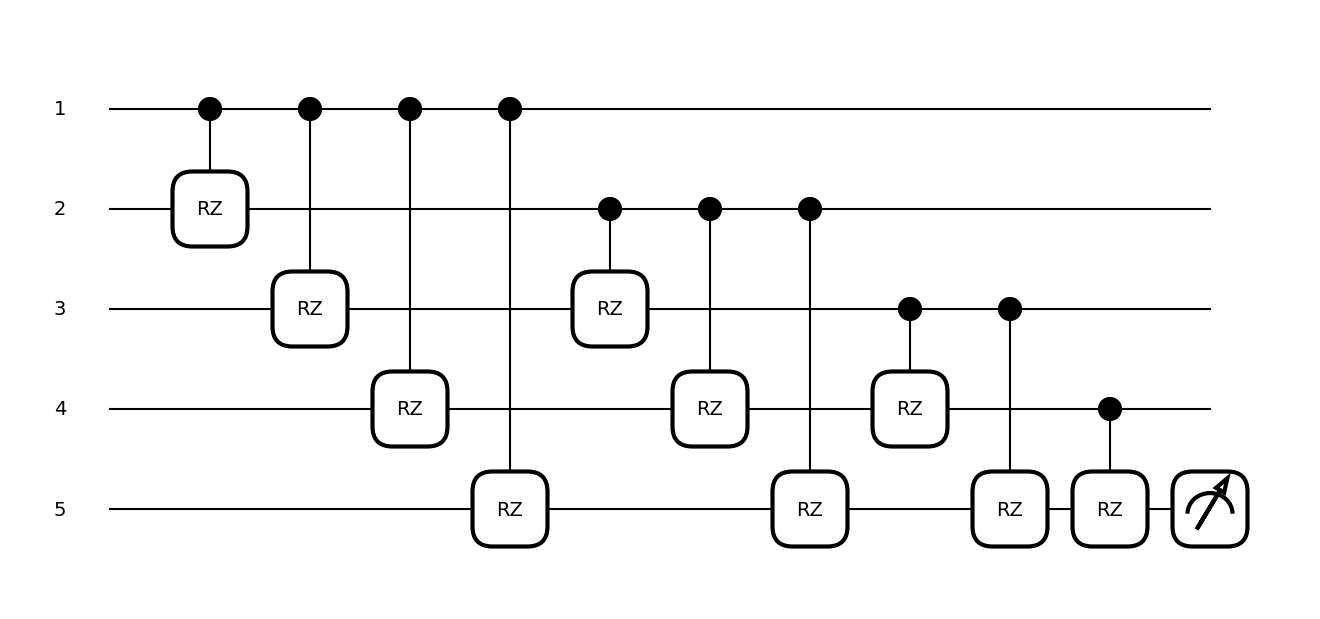

In [13]:
# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(dense_on_5_qubits)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(dense_on_5_qubits, params)

## Reverse binary tree


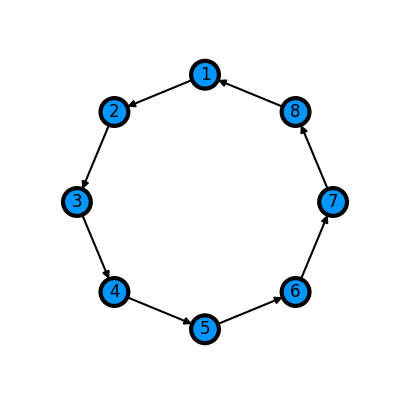
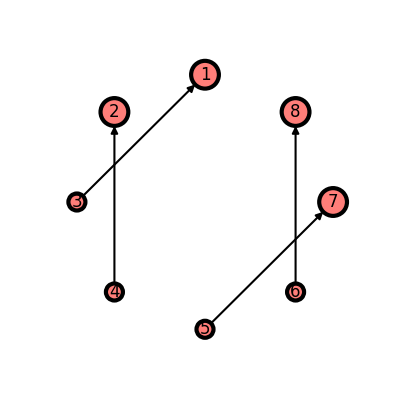
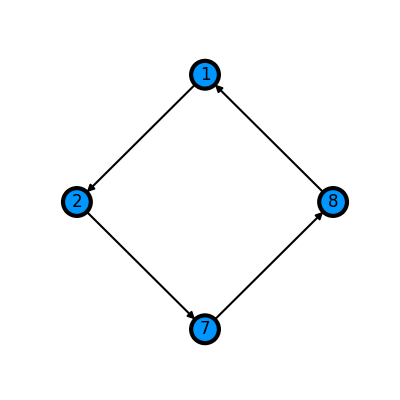
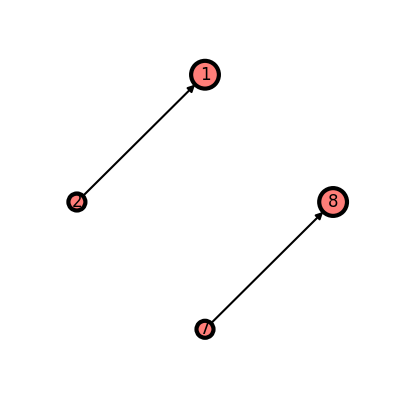
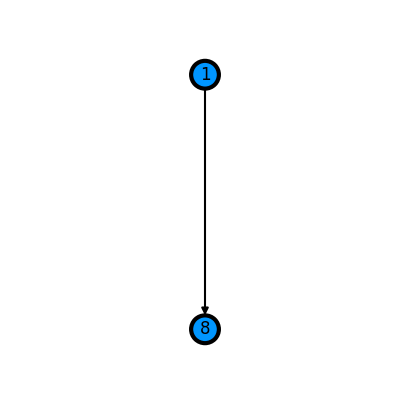
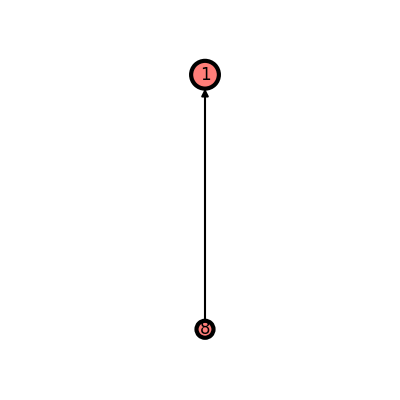

In [14]:
### Reverse binary tree

# Change these values
# ---------
N = 8  # any power of two
s_c = 1  # 1,2,3, ...
f = "inside"  # right, left, inside, outside, even, odd
s_p = 0  # 0,1,2,3, ...
# ---------

# level 1
m1_1 = Qconv(stride=s_c)
m1_2 = Qpool(stride=s_p, filter=f)
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

figs = plot_motifs(m3_1)

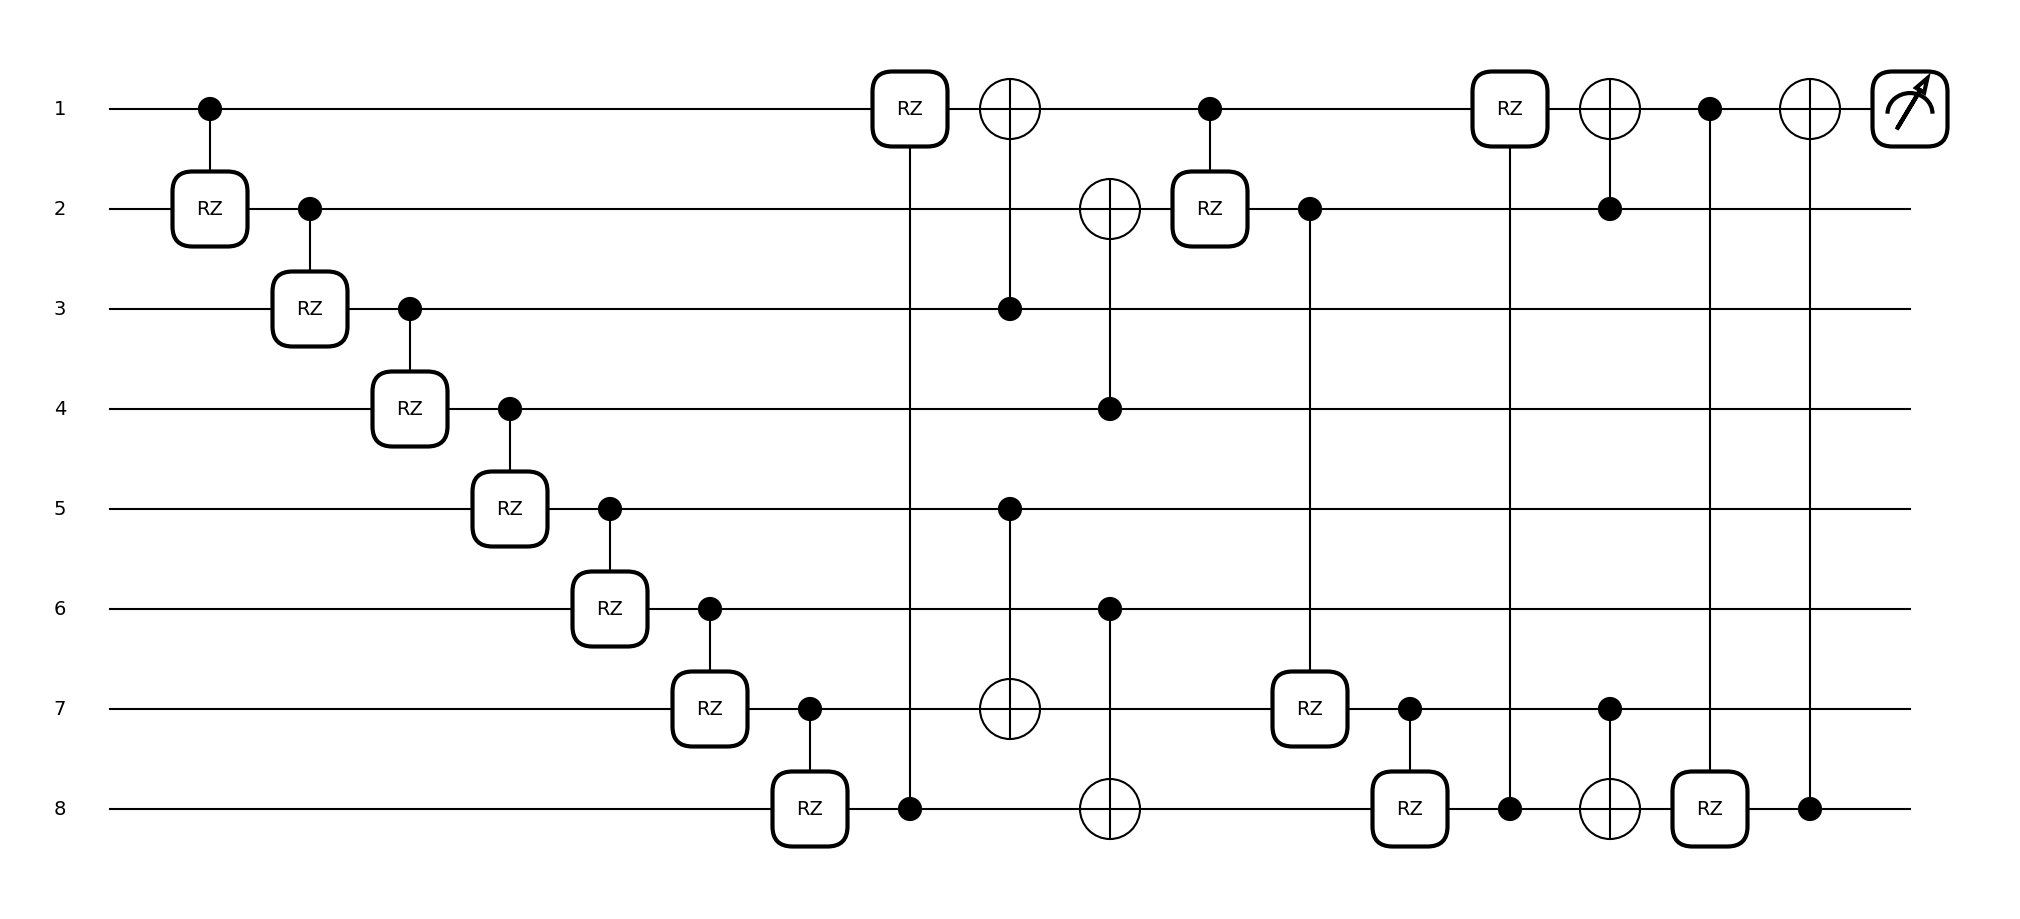

In [15]:
# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(m3_1)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(m3_1, params)

## More arbitrary examples to show what is possible

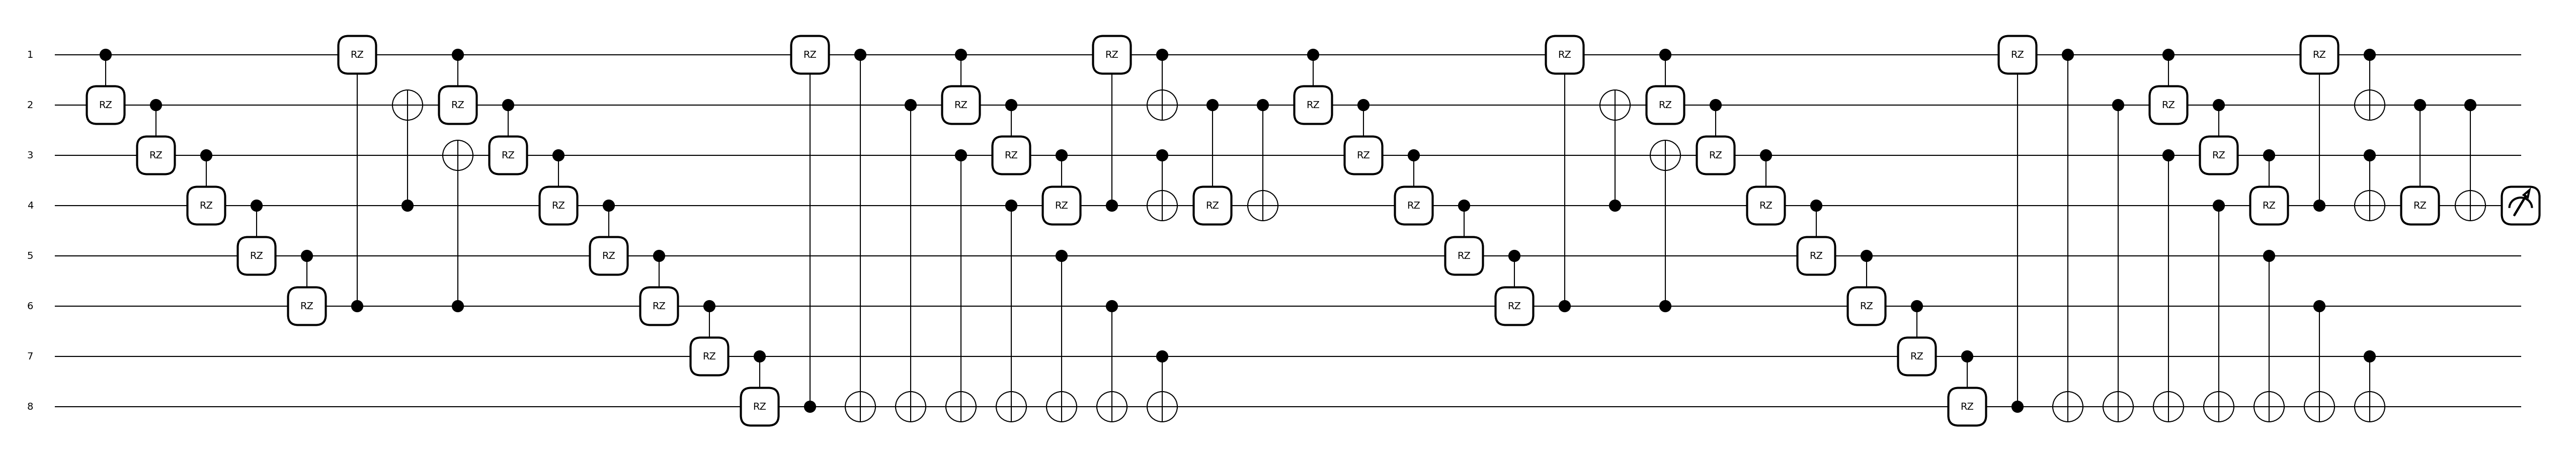

In [16]:
m1 = Qfree(6) + Qconv()
m2 = m1 + Qpool(1, "000101")
m3 = m2 + Qfree(8) + Qconv(1) + Qpool(2, "11111110")
m4 = m3 + Qfree(4) + (Qconv(1) + Qpool(0, "even")) * 2
m5 = m4 + m4

# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(m5)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(m5, params)


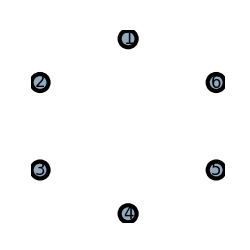
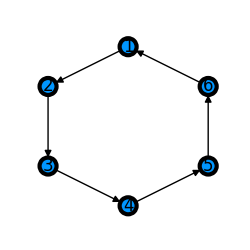
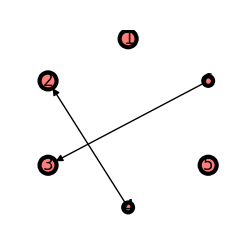
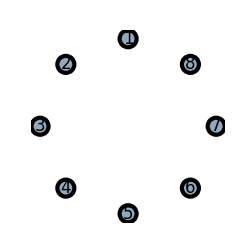
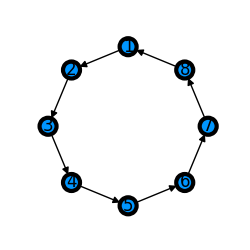
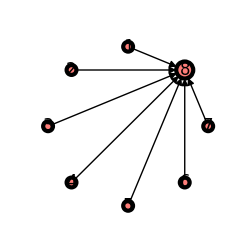
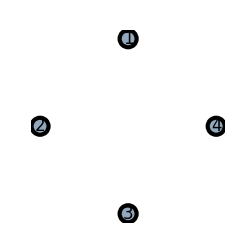
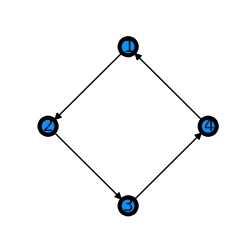
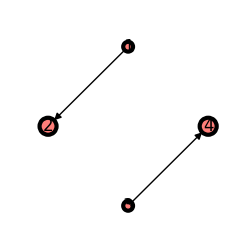
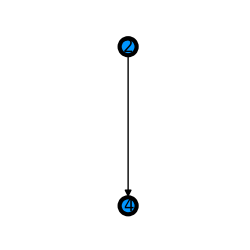
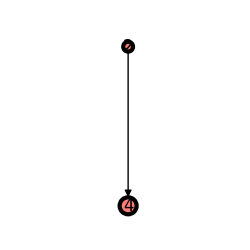
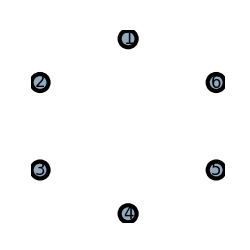
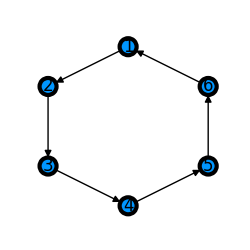
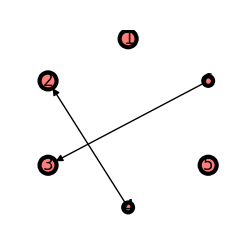
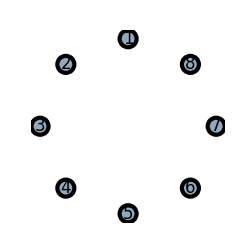
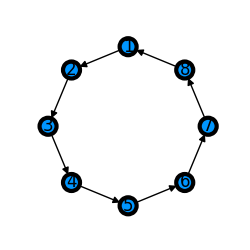
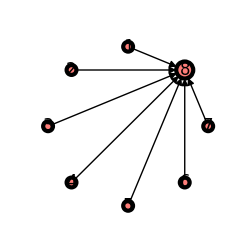
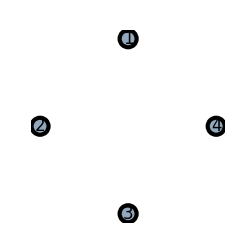
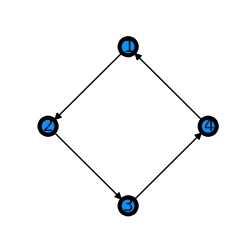
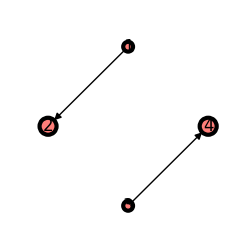
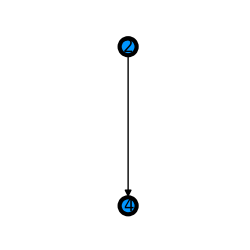
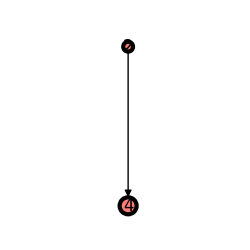

In [17]:
figs = plot_motifs(
    m5, all_motifs=True, figsize=(2.5, 2.5), node_large=150, node_small=50, edge_width=1
)

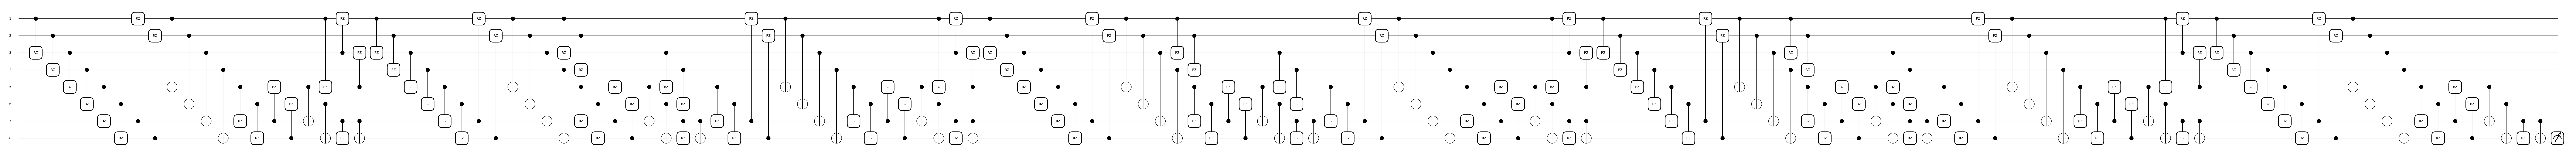

In [18]:
N = 8
# level 1
m1_1 = Qconv(2)
m1_2 = Qpool(filter="left")
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))
final_motif = (m3_1 + Qfree([1, 3, 5]) + Qconv(5) + m3_1) * 4

# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(final_motif)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(final_motif, params)

## Multiscale Entanglement Renormalization Ansatz (MERA)

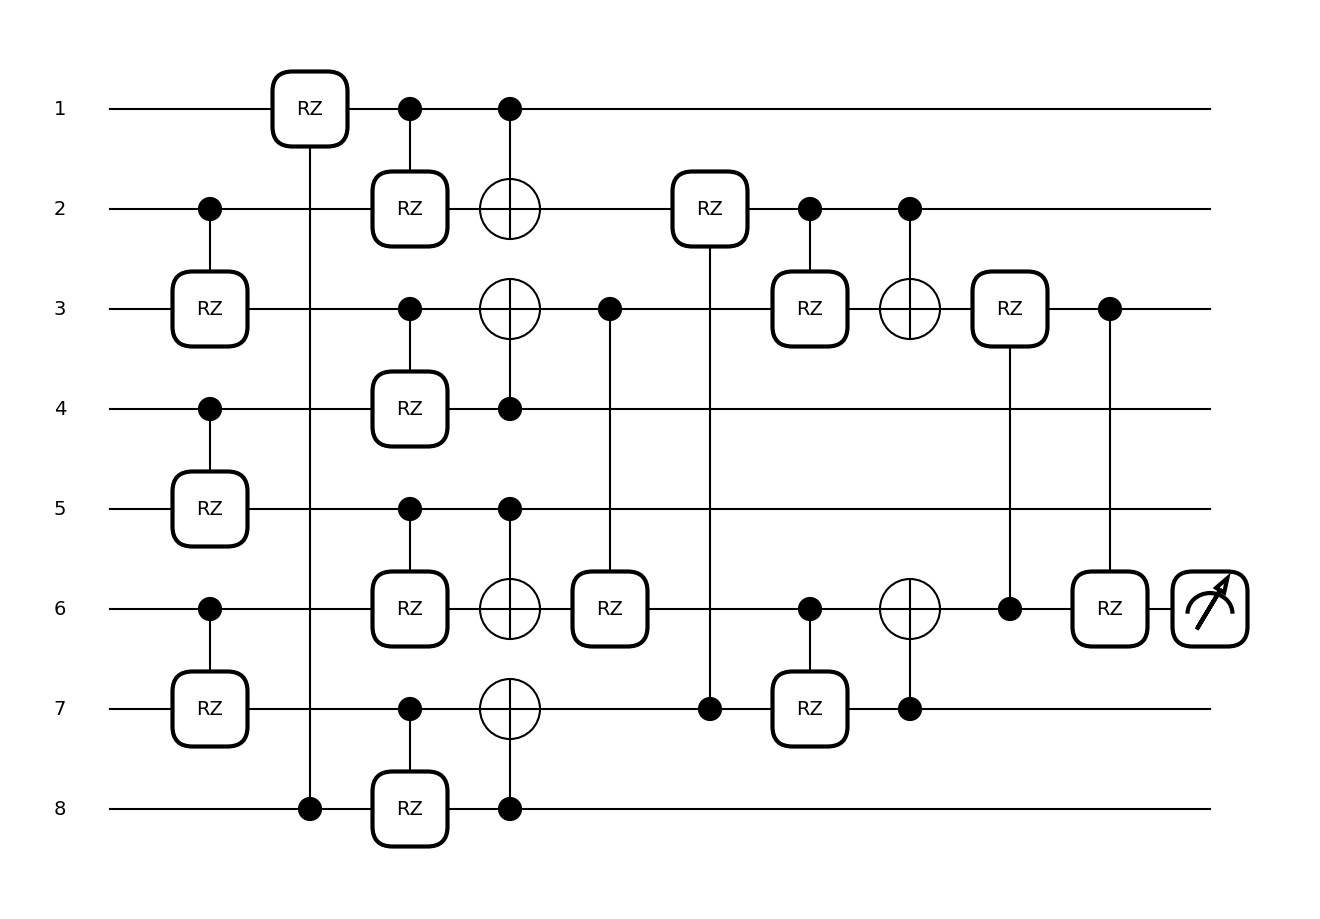

In [19]:
### MERA like
N = 8
# level 1
m1_1 = Qconv(1, 2)
m1_2 = Qconv(1, 2, 1)
m1_3 = Qpool(filter="1001")
m1_4 = Qpool(2, filter="001001")
m1_5 = Qpool(filter="outside")
# level 2
m2_1 = m1_2 + m1_1
m2_2 = m1_3 + m1_4
m2_3 = m1_5
# level 3
m3_1 = Qfree(N) + (m2_1 + m2_2) * 2 + m2_1

# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(m3_1)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(m3_1, params)

## Random QCNNs

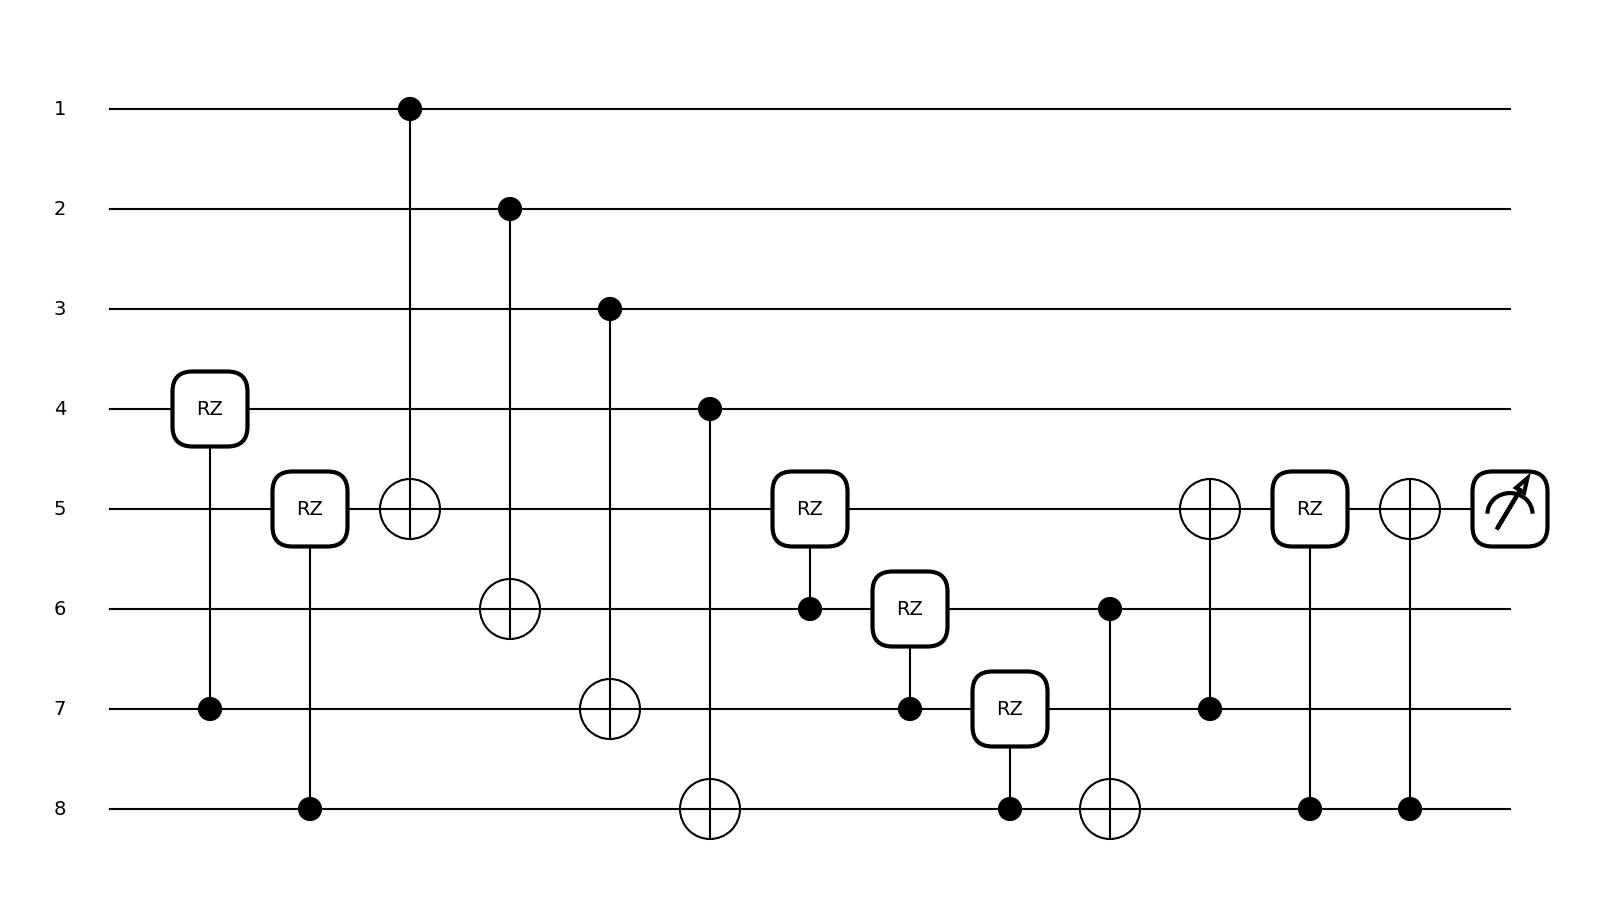

In [20]:
# More structure
import random
import operator
from functools import reduce
from hierarqcal import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ]  # + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(M)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(M, params)

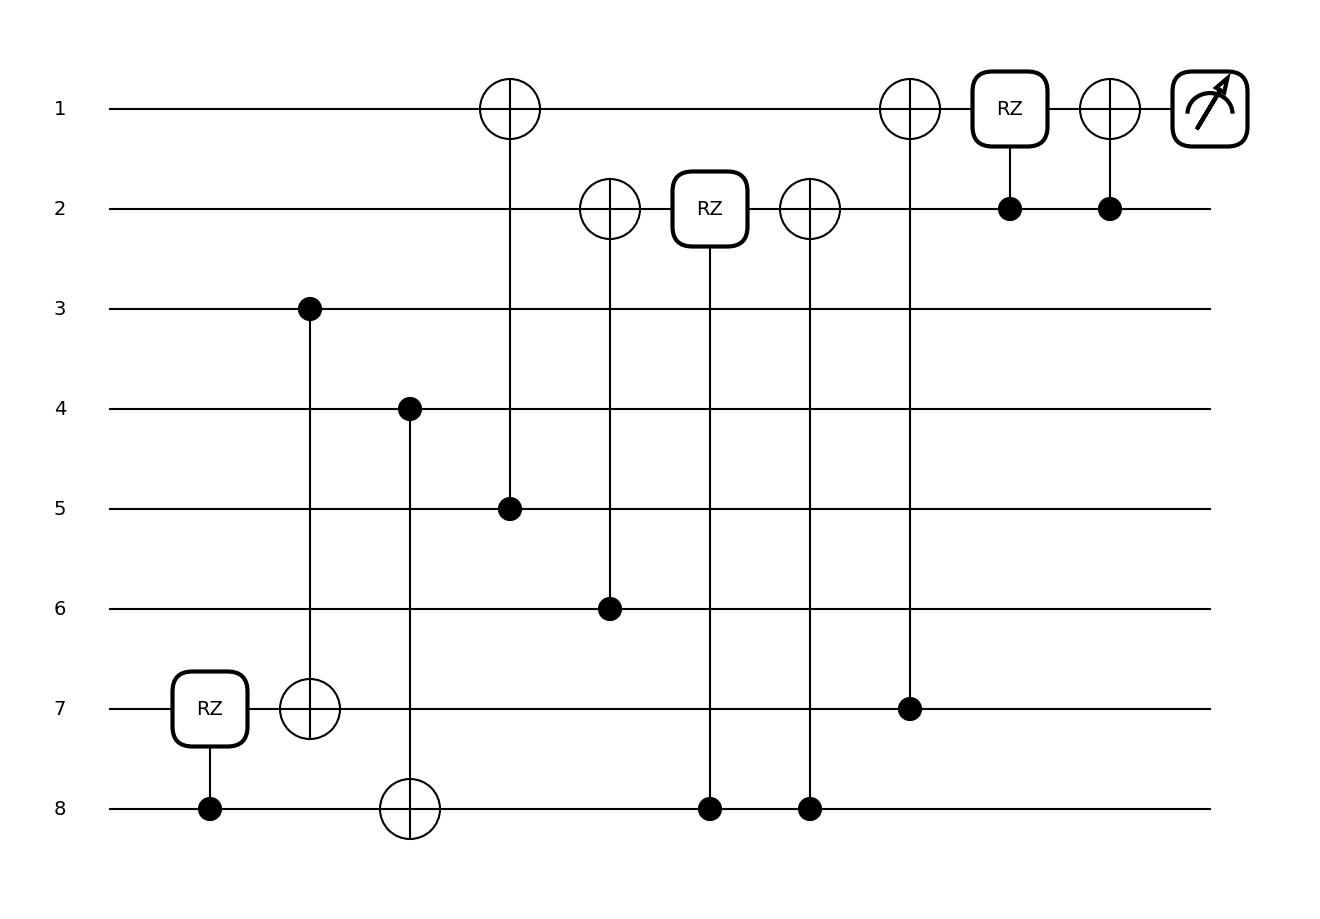

In [21]:
# loose
import random
import operator
from functools import reduce
from hierarqcal import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ] + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(M)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(M, params)

## Specifying unitaries

In [22]:
# Pooling circuit
def V(bits, symbols=None):
    qml.CRZ(symbols[0], wires=[bits[0], bits[1]])
    qml.PauliX(wires=bits[0])
    qml.CRX(symbols[1], wires=[bits[0], bits[1]])


# Convolution circuit
def U(bits, symbols=None):
    qml.RZ(symbols[0], wires=bits[1])
    qml.CNOT(wires=[bits[1], bits[0]])
    qml.RZ(symbols[1], wires=bits[0])
    qml.RY(symbols[2], wires=bits[1])
    qml.CNOT(wires=[bits[0], bits[1]])
    qml.RY(symbols[3], wires=bits[1])
    qml.CNOT(wires=[bits[1], bits[0]])
    qml.RZ(symbols[4], wires=bits[0])

**Convolution**

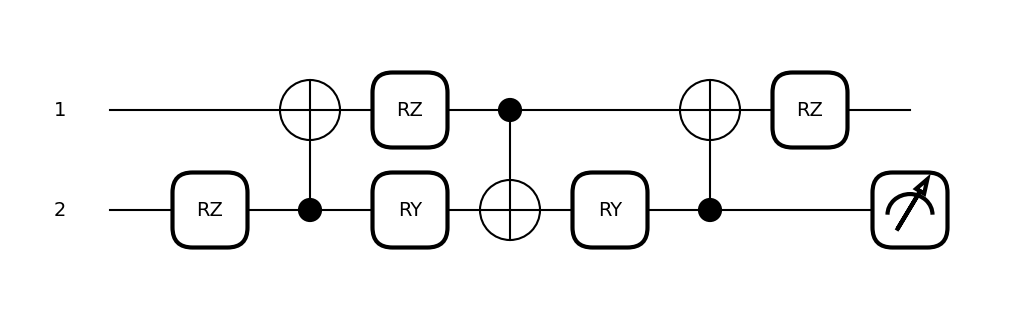

In [23]:
convolution_ansatz = Qfree(2) + Qconv(convolution_mapping=(U, 5))
# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(convolution_ansatz)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(convolution_ansatz, params)

**Pooling**

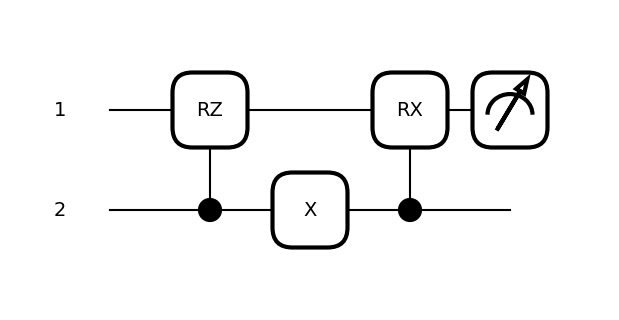

In [24]:
pooling_ansatz = Qfree(2) + Qpool(pooling_mapping=(V, 2))
# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(pooling_ansatz)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(pooling_ansatz, params)

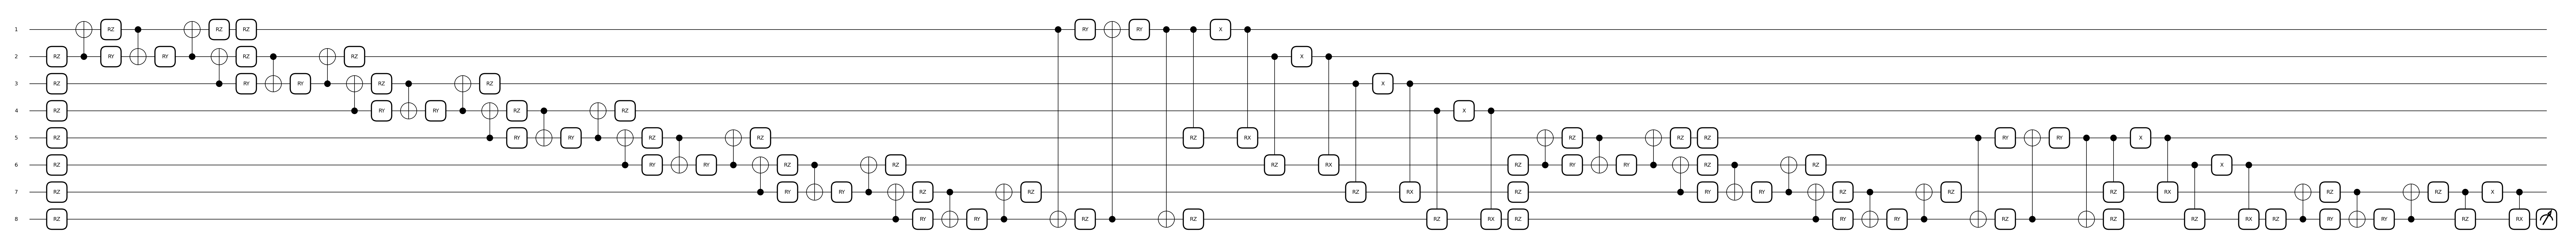

In [25]:
m = (
    Qfree(8)
    + (
        Qconv(1, convolution_mapping=(U, 5))
        + Qpool(filter="left", pooling_mapping=(V, 4))
    )
    * 3
)

# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(m)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(m, params)

### Cycle through unitary ansatzes

In [26]:
# Pooling circuit
def V_1(bits, symbols=None):  # 1
    qml.CRX(symbols[0], wires=[bits[0], bits[1]])


def V_2(bits, symbols=None):  # 0
    qml.CNOT(wires=[bits[0], bits[1]])


# Convolution circuit
def U_1(bits, symbols=None):  # 1
    qml.CRZ(symbols[0], wires=[bits[0], bits[1]])


def U_2(bits, symbols=None):  # 1
    qml.CRY(symbols[0], wires=[bits[0], bits[1]])


function_mappings = {
    "convolution": [(U_1, 1), (U_2, 1)],
    "pooling": [(V_1, 1), (V_2, 0)],
}

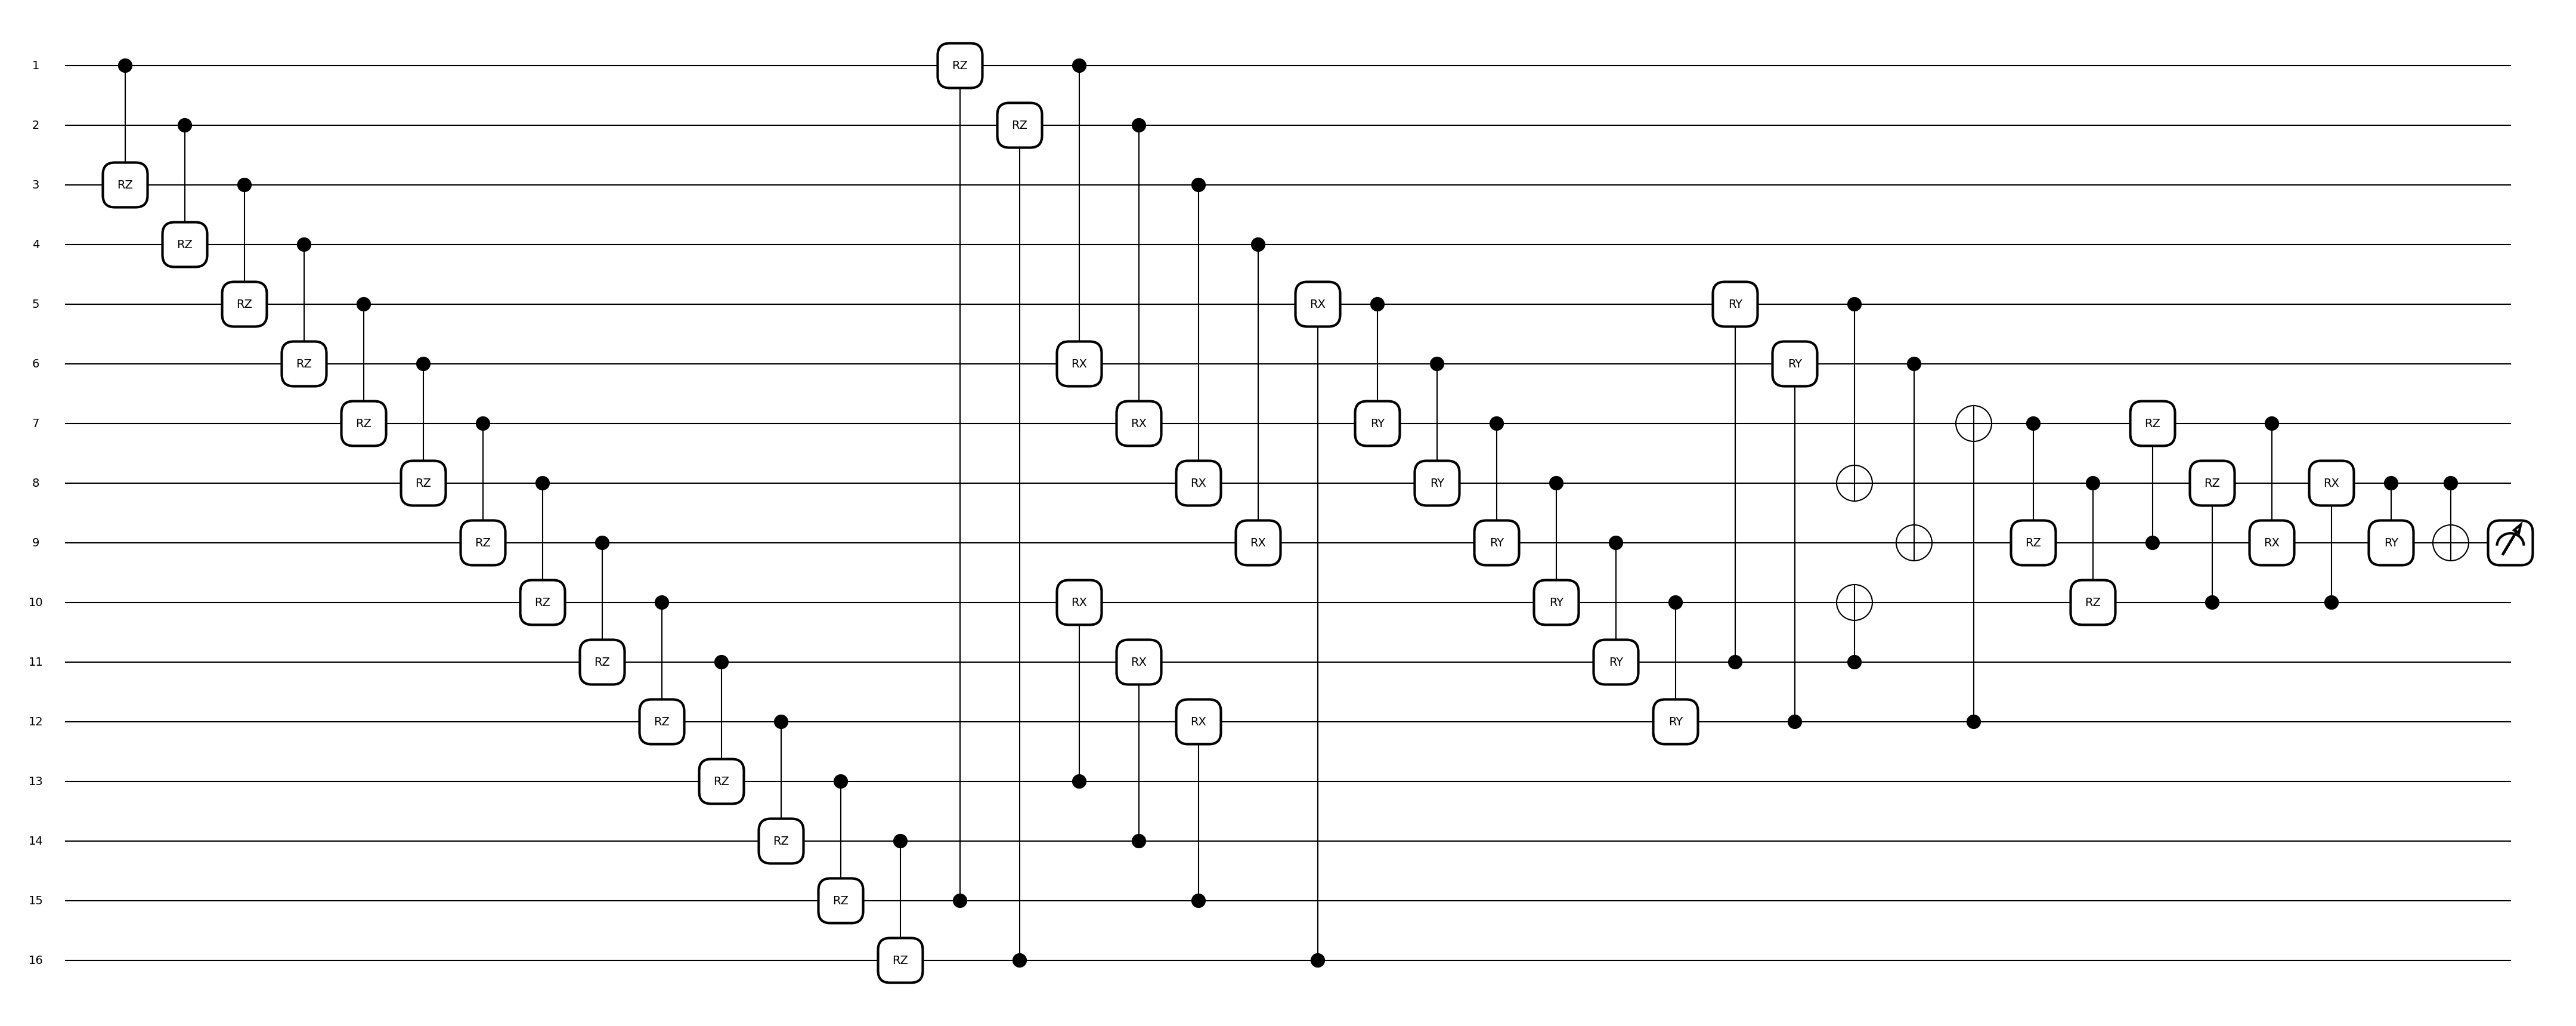

In [27]:
qcnn = Qcnn(16, function_mappings=function_mappings)

qcnn = qcnn + (Qconv(2) + Qpool(1, "outside")) * 4

# Get param info
total_coef_count, coef_indices = get_param_info_pennylane(qcnn)
params = np.random.uniform(0, np.pi, total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(qcnn, params)

## Plotting the directed graph representation

**Plot single motif:**

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

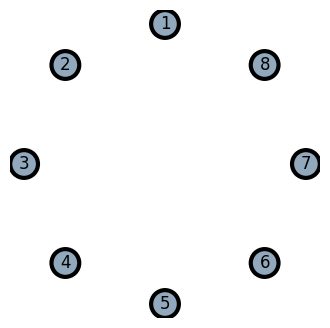

In [28]:
m = Qfree(8) + (Qconv(1) + Qpool(filter="right")) * 3

plot_motif(m.tail)

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

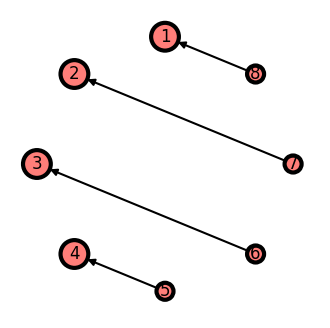

In [29]:
plot_motif(m.tail.next.next)

**Plot full qcnn**


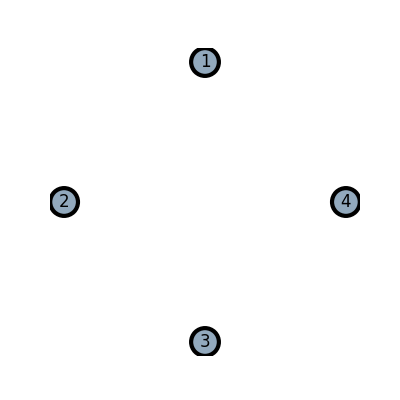
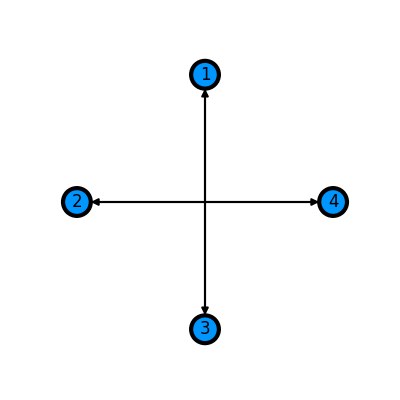
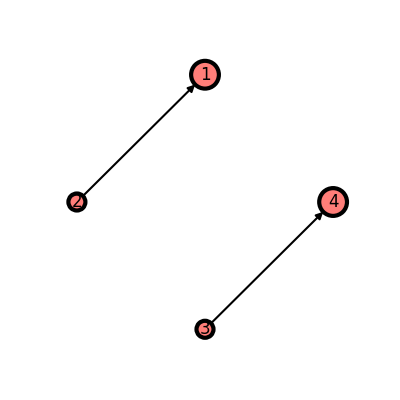
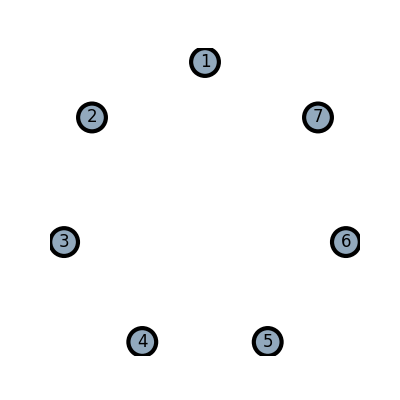
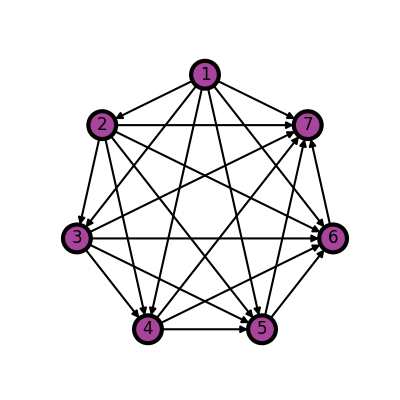
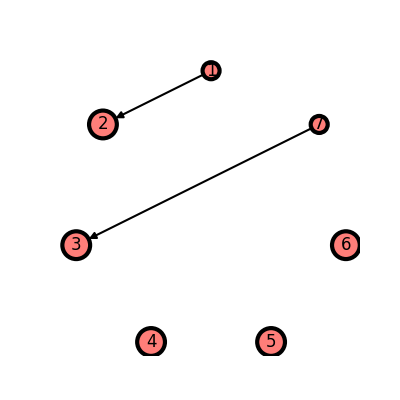

In [30]:
m = (
    Qfree(4)
    + Qconv(2)
    + Qpool(filter="inside")
    + Qfree(7)
    + Qdense()
    + Qpool(filter="1000001")
)
# If all_motifs=false then only operational motifs are plotted, i.e. not Qfree motifs
a = plot_motifs(m, all_motifs=True, figsize=(4, 4))